In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import string
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

In [3]:
claimed = pd.read_csv('Erc20Quest_evt_Claimed.csv')
created = pd.read_csv('QuestFactory_evt_QuestCreated.csv')

claimed.head(5)

,blockchain,contract_address,evt_tx_hash,evt_index,evt_block_time,evt_block_number,account,amount,rewardAddress
0,optimism,0xf0f2ff51d70378902ad721b516147ead8c41b3b5,0x5281f752de3ae7bf0b5013dc3c8888f6060fb6b42d36...,2,2023-04-28 01:11:27.000 UTC,94900000.0,0x1a2b50bb52b322b50d3266f4be8e43944d967e94,1.500000e+17,0x4200000000000000000000000000000000000042
1,optimism,0xd84ec878d3ba1abd2312c79bb98fc897777f2ca9,0xdf2c0144d33c9f4baac26a29494885f53782bd043f95...,2,2023-04-28 00:57:32.000 UTC,94900000.0,0xd6df8b0bb7bc1af0af5f3c62131c85ff5069528a,1.500000e+17,0x4200000000000000000000000000000000000042
2,optimism,0xf0f2ff51d70378902ad721b516147ead8c41b3b5,0x1f5afc3ecdf6c1fc16a572975f02ed376e991ef74e84...,2,2023-04-28 01:08:38.000 UTC,94900000.0,0x6cb0584cea95123c9dc1ba14f060fca9bc3f5469,1.500000e+17,0x4200000000000000000000000000000000000042
3,optimism,0xf0f2ff51d70378902ad721b516147ead8c41b3b5,0x74ebd7ba1420637463bc06c6b0af745928d5656c23f3...,2,2023-04-28 01:08:54.000 UTC,94900000.0,0xbc873307c3148a8dc6b3b9980bd511ab87c88137,1.500000e+17,0x4200000000000000000000000000000000000042
4,optimism,0xf0f2ff51d70378902ad721b516147ead8c41b3b5,0x59f72d9748fb36f45f6dfa4177110084561f19ae377c...,2,2023-04-28 01:14:43.000 UTC,94900000.0,0xf99ee8329beca7ad4bc417e5a04da9d546bd2b97,1.500000e+17,0x4200000000000000000000000000000000000042


In [4]:
# Quests is a dataset combining created and claimed
data = pd.read_csv('quests.csv')
data.head(5)

,blockchain,quest,status,reward,reward_token,participants,total,participation_percent,filled_percentage,usd_distributed,start_time,end_time,etherscan,unclaimed_receipts,quest_type,start_timestamp
0,optimism,"<a href=""https://rabbithole.gg/quests?quest=73...",UPCOMING ⏲️,0.15,OP,0,2000,0.000000,0.000000,NaN,28-04-2023 23:00,29-04-2023 21:00,"<a href=""https://optimistic.etherscan.io/addre...",0,erc20,4/28/23 23:00
1,optimism,"<a href=""https://rabbithole.gg/quests?quest=22...",ACTIVE 🟢,0.15,OP,57,2000,0.028500,0.028500,NaN,27-04-2023 23:00,28-04-2023 22:00,"<a href=""https://optimistic.etherscan.io/addre...",12,erc20,4/27/23 23:00
2,optimism,"<a href=""https://rabbithole.gg/quests?quest=8e...",CLOSED 🔒,0.13,OP,1027,2500,0.410800,0.410800,243.4536,26-04-2023 23:00,27-04-2023 23:00,"<a href=""https://optimistic.etherscan.io/addre...",160,erc20,4/26/23 23:00
3,optimism,"<a href=""https://rabbithole.gg/quests?quest=d9...",CLOSED 🔒,0.13,OP,0,2500,0.000000,0.000000,0.0000,26-04-2023 23:00,27-04-2023 22:30,"<a href=""https://optimistic.etherscan.io/addre...",0,erc20,4/26/23 23:00
4,optimism,"<a href=""https://rabbithole.gg/quests?quest=8c...",CLOSED 🔒,0.15,OP,337,1500,0.224667,0.224667,92.4000,25-04-2023 23:45,26-04-2023 22:00,"<a href=""https://optimistic.etherscan.io/addre...",62,erc20,4/25/23 23:45


In [5]:
# Fill missing values in categorical columns with the most frequent value (mode)
categorical_columns = ['quest', 'status', 'reward_token', 'quest_type']
for column in categorical_columns:
    data[column].fillna(data[column].mode().iloc[0], inplace=True)

In [6]:
# Convert timestamps to datetime objects
data['start_time'] = pd.to_datetime(data['start_time'])
data['end_time'] = pd.to_datetime(data['end_time'])

# Calculate quest duration in hours
data['duration'] = (data['end_time'] - data['start_time']).dt.total_seconds() / 3600

# Drop unnecessary columns
data.drop(columns=['blockchain', 'etherscan', 'unclaimed_receipts', 'start_time', 'end_time', 'start_timestamp'], inplace=True)

data = data.dropna()

# Convert categorical variables (e.g., quest, status, reward_token, quest_type) into dummy variables
data = pd.get_dummies(data, columns=['quest', 'status', 'reward_token', 'quest_type'])

In [7]:
# prediction target is the participation_percent, we will explore both linear and non-linear models
# by predicting the participation_percent instead of the number of participants, we can use the same model for all quests
# This way we also normalize the data, so that we can compare the performance of different models

X = data.drop(columns=['participants'])
y = data['participation_percent']


In [8]:
# Train test split, training data is for training the model, test data is for evaluating the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [9]:
data['duration']

2       24.000000
3       23.500000
4       22.250000
5       23.000000
6       23.383333
          ...    
133     94.250000
134    106.833333
135    143.416667
136    196.500000
137    150.250000
Name: duration, Length: 136, dtype: float64

In [10]:
# Fit a linear regression model, x_train_scaled is the scaled training data, y_train is the training target
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [11]:
linear_model = LinearRegression()
linear_model.fit(X_train_scaled, y_train)

# Predict the number of participants for the testing set
y_pred_linear = linear_model.predict(X_test_scaled)

# Evaluate the model performance
mse_linear = mean_squared_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)

print(f'Linear Regression - Mean squared error: {mse_linear}')
print(f'Linear Regression - R-squared: {r2_linear}')


Linear Regression - Mean squared error: 0.013300918676190831
Linear Regression - R-squared: 0.888454137775407


The MSE is very low although not insignificant. We won't tune the model because for linear models there are very few parameters we can tune.

The results show that we would the x parameters show strong linear correlation to the participation percentage, therefore if we want to increate participation percentrage, we should increate our X factors, which are: reward, duration, filled_percentage.


### Random Forest

In [13]:
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Predict the number of participants for the testing set
y_pred_rf = rf_model.predict(X_test_scaled)

# Evaluate the model performance
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f'Random Forest Regression - Mean squared error: {mse_rf}')
print(f'Random Forest Regression - R-squared: {r2_rf}')


Random Forest Regression - Mean squared error: 6.916431182053721e-05
Random Forest Regression - R-squared: 0.9994199654185539


The result of random forest model is really good, although we need to be cautious because our dataset has only 100+ data and random forest can easily overfit. 

In [13]:
from sklearn.model_selection import GridSearchCV

# RandomForestRegressor hyperparameter tuning
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_

# Train the RandomForestRegressor with the best hyperparameters found
tuned_nonlinear_model = RandomForestRegressor(**best_params, random_state=42)
tuned_nonlinear_model.fit(X_train, y_train)

# Predict the participants on test data
tuned_nonlinear_pred = tuned_nonlinear_model.predict(X_test)

# Calculate the mean squared error and R-squared for the tuned RandomForestRegressor
mse_tuned_nonlinear = mean_squared_error(y_test, tuned_nonlinear_pred)
r2_tuned_nonlinear = r2_score(y_test, tuned_nonlinear_pred)

print(f'Tuned Random Forest Regression:\nMean Squared Error: {mse_tuned_nonlinear}\nR-squared: {r2_tuned_nonlinear}\n')

Tuned Random Forest Regression:
Mean Squared Error: 7.944160483639854e-05
R-squared: 0.9993337766718442



### Hist Gradient Boosting Tree

We are trying a new model, because this model is not allergic to extreme values or nan value or 0s. By using this model, it will make our results more robust. 

In [14]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

# Convert 'participants' column to float
data['participants'] = data['participants'].astype(float)


hist_gradient_model = HistGradientBoostingRegressor(random_state=42)
hist_gradient_model.fit(X_train_scaled, y_train)

# Predict the percent of participants for the testing set
y_pred_hist_gradient = hist_gradient_model.predict(X_test_scaled)

# Evaluate the model 
mse_hist_gradient = mean_squared_error(y_test, y_pred_hist_gradient)
r2_hist_gradient = r2_score(y_test, y_pred_hist_gradient)

print(f'HistGradientBoostingRegressor - Mean squared error: {mse_hist_gradient}')
print(f'HistGradientBoostingRegressor - R-squared: {r2_hist_gradient}')


/Users/suqiyang/Library/Python/3.9/lib/python/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


HistGradientBoostingRegressor - Mean squared error: 0.0009686927938712744
HistGradientBoostingRegressor - R-squared: 0.9918762248267451


### Analysis
This means the  model is almost perfect with a almost 0 MSE, and an almost 1 R squred. 

### Visualization 

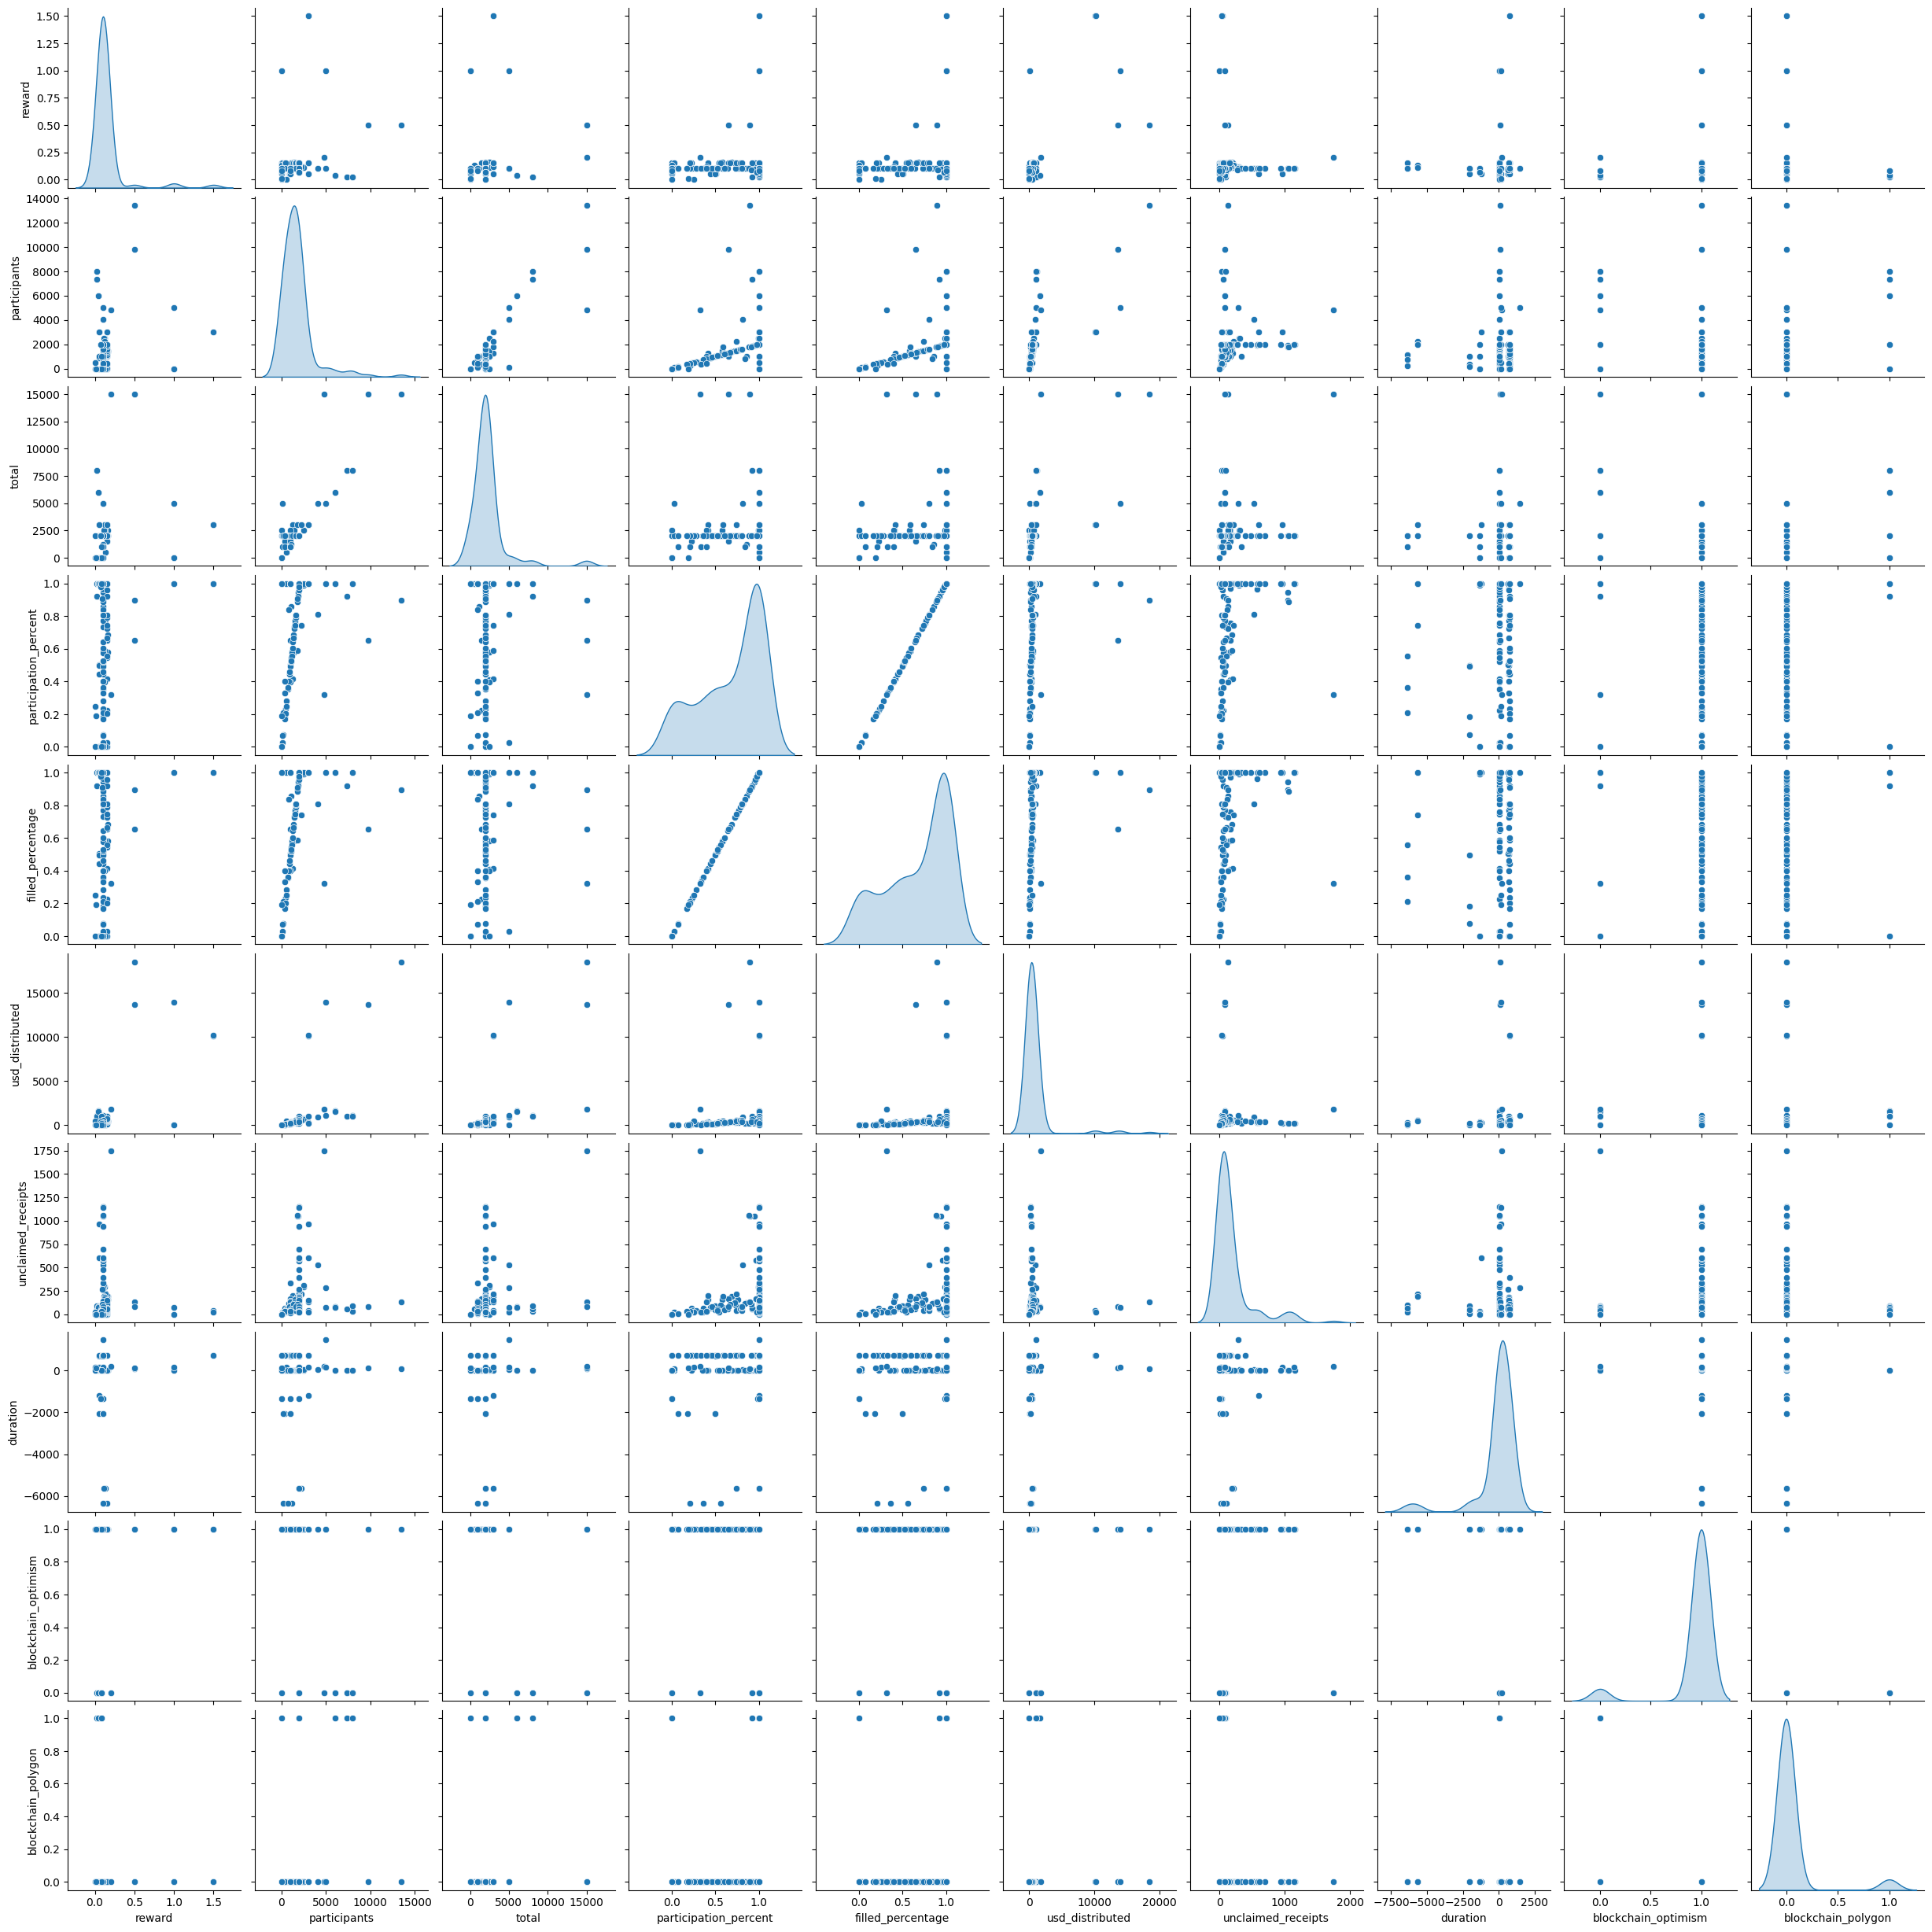

/var/folders/6q/4lnsvv_14yg2wyyzl5vvrbym0000gn/T/ipykernel_4783/2627502466.py:20: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(), annot=True, cmap='coolwarm', center=0)


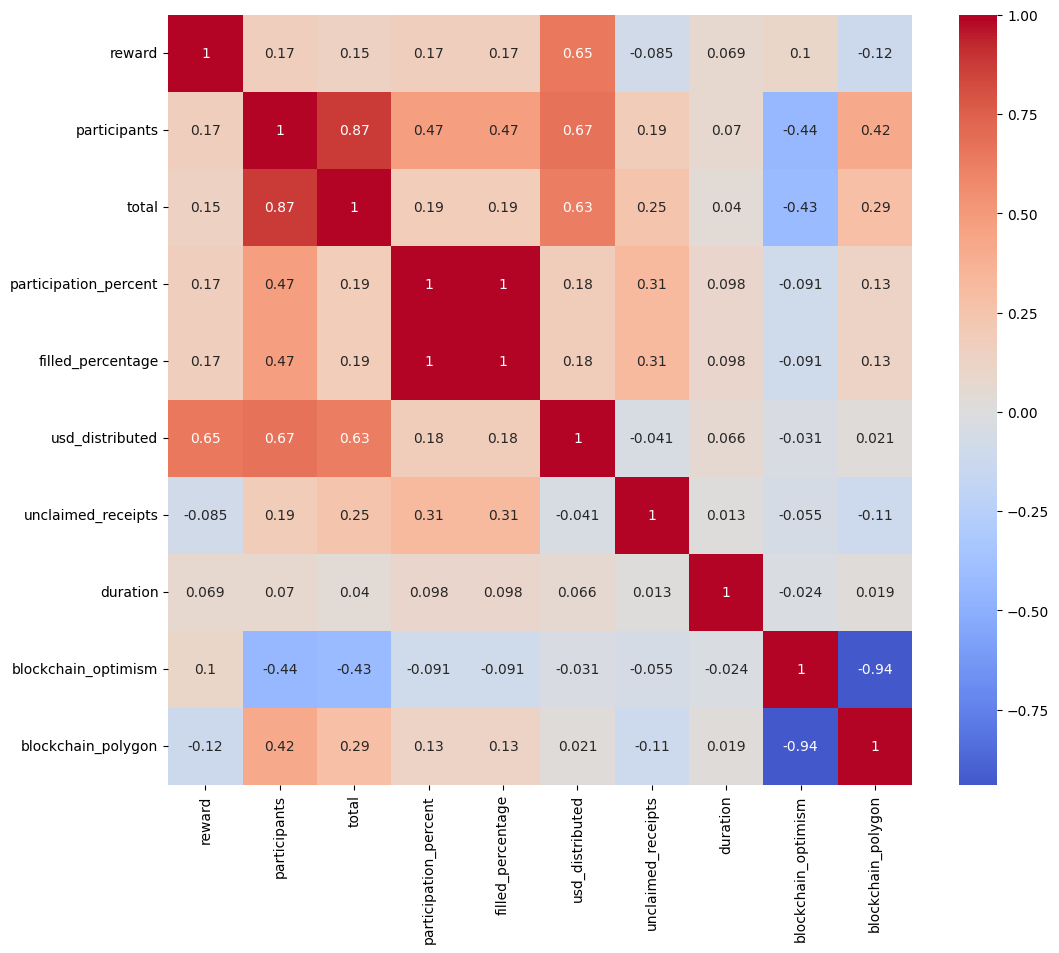

In [15]:
# Read the data
data = pd.read_csv('quests.csv')

# Convert start_time and end_time to datetime
data['start_time'] = pd.to_datetime(data['start_time'])
data['end_time'] = pd.to_datetime(data['end_time'])

# Calculate quest duration in hours
data['duration'] = (data['end_time'] - data['start_time']).dt.total_seconds() / 3600

# Encode categorical variables (blockchain and quest_type)
data = pd.get_dummies(data, columns=['blockchain', 'quest_type'], drop_first=True)

# Pairplot to visualize the relationships between variables
sns.pairplot(data, diag_kind='kde')
plt.show()

# Correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', center=0)
plt.show()